# Exercise: Parallel Monte Carlo (Threads)

**Note: You should use multiple Julia threads for this exercise!**

In [11]:
using Base.Threads
@assert Threads.nthreads() > 1
Threads.nthreads()

4

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

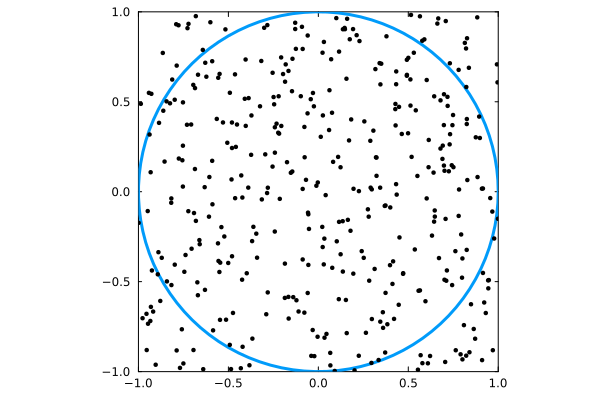

In [12]:
using Plots
using Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1, 1), ylims=(-1, 1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Basic Julia Implementation

In [13]:
function compute_pi(N)
    M = 0 # number of darts that landed in the circle
    for i in 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end
    return 4 * M / N
end

compute_pi (generic function with 1 method)

In [14]:
@btime compute_pi(10_000_000) samples=5 evals=2

  50.351 ms (0 allocations: 0 bytes)


3.1413144

### Tasks

1. Based on `compute_pi`, write a parallel version `compute_pi_parallel(N::Int)` that divides the work into `Threads.nthreads()` parallel tasks. The final estimate for π should be the average of the estimate of each task. 
    1. **Hint:** Be aware of false sharing, that is, make sure that every tasks operates locally and only shares the local result at the end.
    2. **Hint:** You may call the serial `compute_pi` in your code.
    3. **Hint:** If you want, implement two versions, one based on `@threads` and another using `@spawn`.

2. Benchmark and compare the serial and parallel variants.
    1. **Hint:** A reasonable value for $N$ could be `N = 10_000_000`.

In [1]:
using BenchmarkTools
using Base.Threads

In [2]:
function compute_pi_parallel(N)
    nchunks = Threads.nthreads()
    psums = zero(Int)
    @threads for _ in 1:nchunks
        local M = 0 # number of darts that landed in the circle
        @simd for _ in 1:N/nchunks
            if sqrt(rand()^2 + rand()^2) < 1.0
                M += 1
            end
        end
        psums += M
    end
    return 4 * psums / N
end

@btime compute_pi_parallel(10_000_000) samples=5 evals=2

  12.470 ms (33 allocations: 2.39 KiB)


3.1425088

In [42]:
using ChunkSplitters

function compute_pi_parallel_spawn(N)
    ntasks = Threads.nthreads()
    psums = zeros(Int, ntasks)
    @sync for (cid, chunk) in enumerate(chunks(1:N; n=ntasks))
        @spawn begin
            local M = 0 # number of darts that landed in the circle
            for _ in chunk
                if sqrt(rand()^2 + rand()^2) < 1.0
                    M += 1
                end
            end
            psums[cid] = M
        end
    end
    return 4 * sum(psums) / N
end

@btime compute_pi_parallel_spawn(10_000_000) samples=5 evals=2

  12.593 ms (34 allocations: 2.64 KiB)


3.1414616

3. Write a function `compute_pi_multiple(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in serial** computes $\pi$ for all these values. The function should be entirely serial and based on `compute_pi`. Benchmark and compare to the previous variants.

In [18]:
some_Ns = [10, 100, 1000, 10_000, 100_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000]

function compute_pi_multiple(some_Ns)
    for N in some_Ns
        compute_pi(N)
    end
end

@btime compute_pi_multiple(some_Ns) samples=5 evals=2

  52.987 ms (0 allocations: 0 bytes)


4. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in parallel** computes $\pi$ for all these values. The function should still be based on the serial `compute_pi`. Benchmark and compare to the previous variants.
    1. **Hint:** You shouldn't use `@threads` here. Do you know why? Think about the input values and the resulting computational cost. You can also write a version with `@threads` and one with `@spawn` and compare the performance.

In [25]:
some_Ns = [10, 100, 1000, 10_000, 100_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000]

function compute_pi_multiple_parallel(Ns::Vector{Int})
    for N in Ns
        @spawn compute_pi(N)
    end        
end

@btime compute_pi_multiple_parallel($some_Ns) samples=5 evals=2

  1.547 μs (45 allocations: 4.39 KiB)


5. Calculate $\pi$ estimates for the following $N$ values: `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.

In [26]:
# N values (nothing todo here)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)));

In [46]:
# Important: the resulting pi estimates should be stored in a variable named: pis
tasks = map(Ns) do N 
    @spawn compute_pi_parallel_spawn(N)
end
pis = fetch.(tasks)


50-element Vector{Float64}:
 3.2
 3.142857142857143
 3.6
 2.962962962962963
 3.3684210526315788
 3.5384615384615383
 2.8333333333333335
 3.0
 3.223021582733813
 3.3402061855670104
 3.197026022304833
 3.163538873994638
 3.166023166023166
 ⋮
 3.141190802088645
 3.142563272716932
 3.1421547550668745
 3.1401296427037524
 3.1424588
 3.1424476005859683
 3.1417148763519593
 3.1417431674511884
 3.141385630590973
 3.141576654481969
 3.1419394644617635
 3.14153892

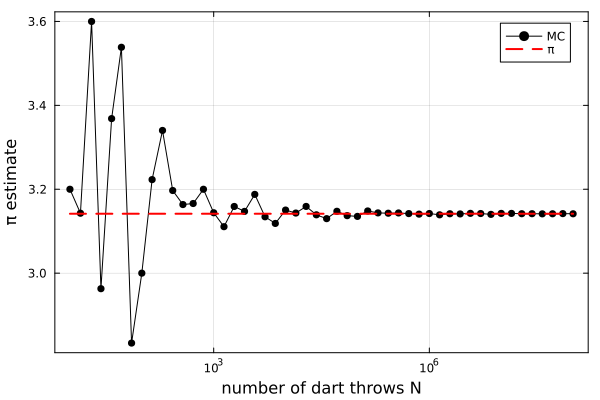

In [47]:
# Plotting (nothing todo here)
plot(Ns, pis, color=:black, marker=:circle, lw=1, label="MC", xscale=:log10, frame=:box)
plot!(x -> π, label="π", xscale=:log10, linestyle=:dash, color=:red, lw=2)
ylabel!("π estimate")
xlabel!("number of dart throws N")

6. **Bonus:** Try to write a function `compute_pi_multiple_nested_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values using nested multithreading: Both the outer computation ("for each N in Ns") as well as the inner computation ("compute pi for a given N") should be parallelized. Benchmark and compare to the previous variants.

In [ ]:
some_Ns = [10, 100, 1000, 10_000, 100_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000]

# TODO...

# @btime compute_pi_multiple_nested_parallel($some_Ns) samples=5 evals=2

# from above, for comparison
# @btime compute_pi_multiple_parallel($some_Ns) samples=5 evals=2